## Read glove sensor data

In [372]:
# import glove sensor data from CSV files
from __future__ import print_function
import numpy as np
g_data_r = np.genfromtxt("glove_rock.csv", dtype=np.float, delimiter=",")
g_data_p = np.genfromtxt("glove_paper.csv", dtype=np.float, delimiter=",")
g_data_s = np.genfromtxt("glove_scissors.csv", dtype=np.float, delimiter=",")

# merge all to g_data
g_data = np.append(g_data_r, g_data_p, axis=0)
g_data = np.append(g_data, g_data_s, axis=0)
print("Glove sensor data: \n" + str(g_data))

Glove sensor data: 
[[ 1019.   492.   739.]
 [ 1023.   492.   737.]
 [ 1019.   491.   738.]
 ..., 
 [  582.     0.   441.]
 [  583.     0.   442.]
 [  584.     0.   441.]]


## Create labels

In [373]:
# create arrays for labels
g_label_r = np.tile([1, 0, 0], (g_data_r.shape[0], 1))
g_label_p = np.tile([0, 1, 0], (g_data_p.shape[0], 1))
g_label_s = np.tile([0, 0, 1], (g_data_s.shape[0], 1))
g_label = np.append(g_label_r, g_label_p, axis=0)
g_label = np.append(g_label, g_label_s, axis=0)
print("Glove posture labels: \n" + str(g_label))

Glove posture label: 
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ..., 
 [0 0 1]
 [0 0 1]
 [0 0 1]]


## Standardize data

In [374]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
g_data = scaler.fit_transform(g_data)
print("Standardized Glove data: \n" + str(g_data))

Standardized Glove data: 
[[ 0.99608993  0.7872      0.85730858]
 [ 1.          0.7872      0.8549884 ]
 [ 0.99608993  0.7856      0.85614849]
 ..., 
 [ 0.56891496  0.          0.51160093]
 [ 0.56989247  0.          0.51276102]
 [ 0.57086999  0.          0.51160093]]


## Plot the data

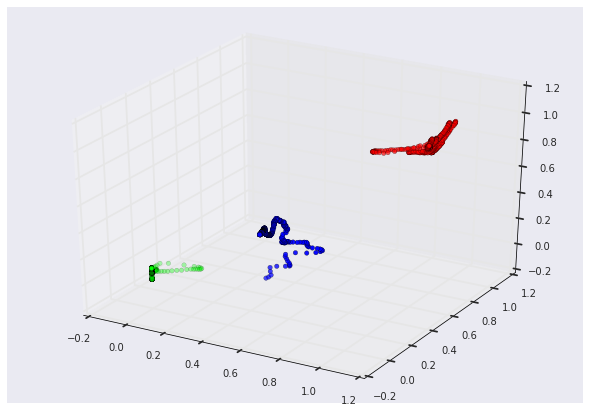

In [423]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(g_data[:,0], g_data[:,1], g_data[:,2], c=g_label)
plt.show()

## Define a logistic regression model

In [376]:
# define the model
import tensorflow as tf
weights = tf.Variable(tf.zeros([3, 3]), dtype=tf.float32)
biases = tf.Variable(tf.zeros([3]), dtype=tf.float32)
data = tf.placeholder(tf.float32)
logits = tf.matmul(data, weights) + biases

# define the loss
labels = tf.placeholder(tf.float32)
loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=logits)

# define the optimizer
train = tf.train.GradientDescentOptimizer(1).minimize(loss)

## Train the model

In [377]:
# init a Session
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# train the model
for i in range(10000):
  
  # train the model
  sess.run(train, {data: g_data, labels: g_label})

  # print current loss
  if i % 1000 == 0:
    l = sess.run(loss, {data: g_data, labels: g_label})
    print("steps = {}, loss = {:f}".format(i, l))

steps = 0, loss = 0.978381
steps = 1000, loss = 0.010096
steps = 2000, loss = 0.005078
steps = 3000, loss = 0.003402
steps = 4000, loss = 0.002562
steps = 5000, loss = 0.002057
steps = 6000, loss = 0.001719
steps = 7000, loss = 0.001478
steps = 8000, loss = 0.001296
steps = 9000, loss = 0.001154


## Plot probability distribution

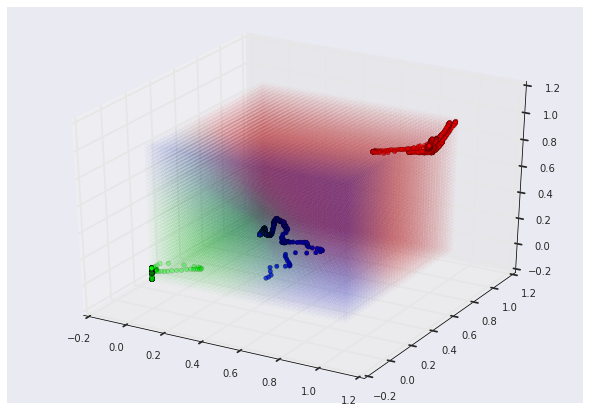

In [382]:
# generate 3D grid positions
pos = [[x,y,z]
       for x in np.linspace(g_data[:,0].min(), g_data[:,0].max(), 40)
       for y in np.linspace(g_data[:,1].min(), g_data[:,1].max(), 40)
       for z in np.linspace(g_data[:,2].min(), g_data[:,2].max(), 40)]

# get softmax value for each position
colors = sess.run(tf.nn.softmax(logits), {data: pos})

# get x, y, z values for each position
xs = [x for [x,y,z] in pos]
ys = [y for [x,y,z] in pos]
zs = [z for [x,y,z] in pos]

# plot 3D scatter graph with softmax value
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xs, ys, zs, c=colors, marker='o', alpha=0.02)
ax.scatter(g_data[:,0], g_data[:,1], g_data[:,2], c=g_label)
plt.show()

## Print Arduino code for the trained parameters

In [383]:
# print weights
print("float weights[3][3] = {")
for v in sess.run(weights):
  print("  {{{:f},{:f},{:f}}},".format(v[0], v[1], v[2]))
print("};\n")

# print biases
v = sess.run(biases)
print("float biases[3] = {{{:f},{:f},{:f}}};\n".format(v[0], v[1], v[2]))

# print scaling
v = scaler.scale_
print("float scaling[3] = {{{:f},{:f},{:f}}};\n".format(v[0], v[1], v[2]))

float weights[3][3] = {
  {3.007032,-9.370312,6.363242},
  {10.726093,-0.494137,-10.231989},
  {3.132884,-6.927588,3.794688},
};

float biases[3] = {-5.709740,6.722741,-1.013021};

float scaling[3] = {0.000978,0.001600,0.001160};

